In [1]:
import numpy as np
from statistics import mean
from math import exp, pi, atan, nan
import matplotlib.pyplot as plt
from KERNEL import est_kernel
from TV_REG import tv_regularize
from GCV import run_gcv
from scipy.optimize import minimize
from scipy.special import erf

In [3]:
def diff(sig, s):
    d = np.zeros(s)
    for i in range(s):
        if i == 0 or i == s-1:
            d[i] = 0
        else:
            d[i] = (sig[i+1] - sig[i-1]) / 2.
    return d


def norm(sig):
    s = sum(sig)
    n = [i / s for i in sig]
    return n


def logistic(L, k, x0, length):
    y = []
    for x in range(length):
        v = L / (1 + exp(-k*(x-x0)))
        y.append(v)
    return y


def arctan2(le, x0, a):
    y = []
    ipi = 1./pi
    for x in range(le):
        xp = x-x0
        v = (a[0]/2)*(1+erf(a[1] * xp)) + a[2]*(ipi * atan(a[3] * xp) + 0.5) + a[4]*(ipi * atan(a[5] * xp) + 0.5) + a[6]*(ipi * atan(a[7] * xp) + 0.5)
        y.append(v)
    return y

def fitter(le, x0, a):
    y = []
    ipi = 1./pi
    for x in range(le):
        xp = x-x0
        v = (a[0]/2)*(1+erf(a[1] * xp)) + a[2]*(ipi * atan(a[3] * xp) + 0.5) + a[4]*(ipi * atan(a[5] * xp) + 0.5) + a[6]*(ipi * atan(a[7] * xp) + 0.5) + a[8]/(1+exp(-a[9]*xp))
        y.append(v)
    return y


In [ ]:
# Open PPM and convert to a list
with open(r"C:\Users\TJ\DataspellProjects\TV_Implementation\sample.pgm", 'rb') as pgmf:
    im = plt.imread(pgmf)

sig = []
for i in im[0]:
    sig.append(i)

# Normalize List
mi = min(sig)
for i in range(len(sig)):
    sig[i] = (sig[i]-mi)
ma = max(sig)
for i in range(len(sig)):
    sig[i] = sig[i]/ma

In [4]:
x = []
for i in range(512):
    if i < 256:
        x.append(0.)
    else:
        x.append(1.)
x = np.asarray(x).reshape(len(x), 1)
from BLUR import blur
from KERNEL import kernel
A = kernel(x.shape[0], 10)
b = list(blur(x, A, True, 0.012))

sig = []
for i in b:
    sig.append(float(i))

sig = sig[156:356]

In [5]:
def logcomp(x, arg):
    le = len(arg)
    x0 = le // 2
    log = logistic(x[0], x[1], x0, le)
    return mean(abs(a - b) for a, b in zip(arg, log))

o = [1., 1.]
test = minimize(logcomp, o, args=sig, bounds=((0., 10000.),(0., 10000.)))

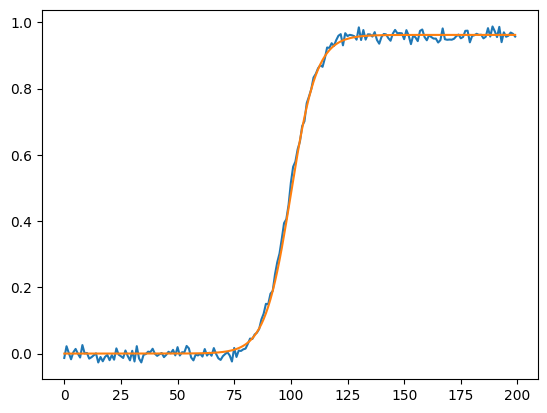

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.011046127632043214
        x: [ 9.620e-01  1.758e-01]
      nit: 17
      jac: [ 7.673e-03 -3.725e-03]
     nfev: 153
     njev: 51
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [7]:
t = test['x']
lo =  logistic(t[0], t[1], len(sig)//2, len(sig))

dk = diff(sig, len(sig))
ndlo = norm(diff(lo, len(lo)))
plt.plot(sig)
plt.plot(lo)
plt.show()

print(test)

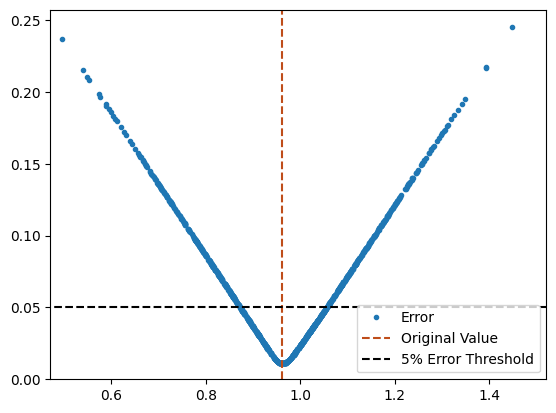

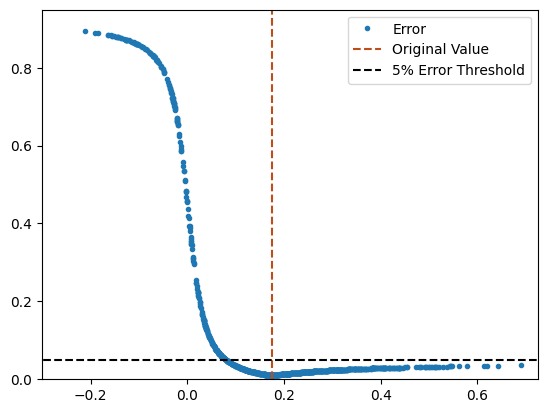

In [31]:
leng = len(sig)
x0 = len(sig) // 2
l = t[0]
k = t[1]

lv = []
kv = []
for i in range(1000):
    lv.append(l + np.random.normal(0, 0.15, size=None))
    kv.append(k + np.random.normal(0, 0.15, size=None))

lve = []
kve = []
for i in lv:
    xs = [i, k, x0, leng]
    lve.append(logcomp(xs, sig))
for j in kv:
    xs = [l, j, x0, leng]
    kve.append(logcomp(xs, sig))

plt.plot(lv, lve, '.')
plt.vlines(l, 0, 1, [0.75, 0.3, 0.1], linestyles='dashed')
plt.hlines(0.05, 0, 100, [0, 0, 0], linestyles='dashed')
plt.xlim([min(lv)-min(lv)*0.05, max(lv)+max(lv)*0.05])
plt.ylim([0, max(lve)+max(lve)*0.05])
plt.legend(["Error", "Original Value", "5% Error Threshold"])
plt.show()

plt.plot(kv, kve, '.')
plt.vlines(k, 0, 1, [0.75, 0.3, 0.1], linestyles='dashed')
plt.hlines(0.05, -100, 100, [0, 0, 0], linestyles='dashed')
plt.xlim([min(kv)-min(kv)*0.05, max(kv)+max(kv)*0.05])
plt.ylim([0, max(kve)+max(kve)*0.05])
plt.legend(["Error", "Original Value", "5% Error Threshold"])
plt.show()

In [8]:
def arccomp(x, arg):
    le = len(arg)
    x0 = le // 2
    arc = arctan2(le, x0, x)
    return mean(abs(a - b) for a, b in zip(arg, arc))

t = [1., 1., 1., 1., 1., 1., 1., 1.]
out = minimize(arccomp, t, args=sig)


In [9]:
point = out['x']
lo =  arctan2(len(sig), len(sig)//2, point)
ndlo = norm(diff(lo, len(lo)))

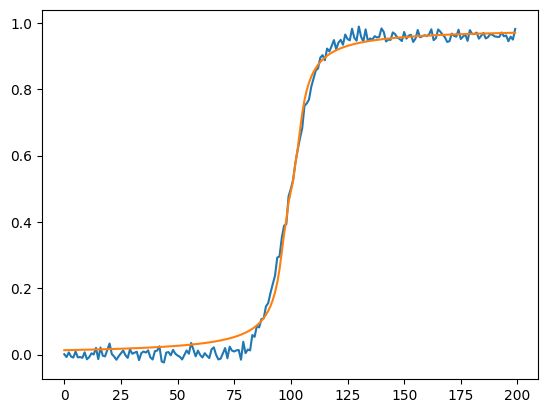

In [10]:
def mixcomp(x, arg):
    le = len(arg)
    x0 = le // 2
    mix = fitter(le, x0, x)
    return mean(abs(a-b) for a,b in zip(arg, mix))

t = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
out = minimize(mixcomp, t, args=sig)
point = out['x']
lo = fitter(len(sig), len(sig)//2, point)
ndlo = norm(diff(lo, len(lo)))
plt.plot(sig)
plt.plot(lo)
plt.show()

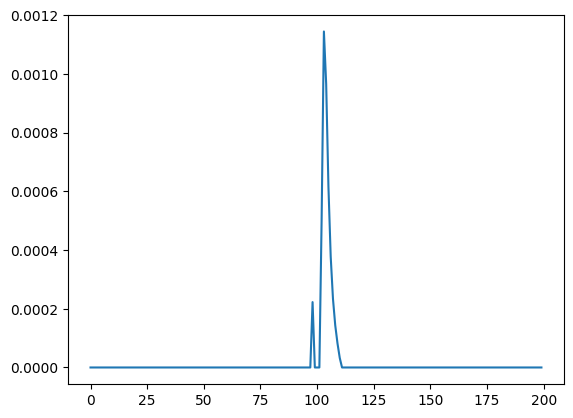

In [10]:
from abel_main import abel_transform
# kern = est_kernel()
PSF = abel_transform(ndlo)
plt.plot(PSF)
plt.show()